In [385]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

print(f"PyMC3 Version {pm.__version__}")

%matplotlib inline

PyMC3 Version 3.5


# Dice, Polls & Dirichlet Multinomials

As part of a longer term project to learn Bayesian Statistics, I'm currently reading [Bayesian Data Analysis, 3rd Edition](http://www.stat.columbia.edu/~gelman/book/) by Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin, commonly known as **BDA3**.
Although I've been using Bayesian statistics and probabilistic programming languages, like [PyMC3](https://docs.pymc.io/), in projects for the last year or so, this book forces me to go beyond a pure practioner's approach to modeling while still delivering very practional value.

Below are a few take aways from the earlier chapters in the book I found interesting. They are meant to hopefully inspire others to learn about Bayesian statistics, without trying to be overly formal about the math. If someone doesn't look 100% to the trained mathematicians in the room, please let me know, or just squint a little harder. ;)

## Conjugates
In Chapter 2 of the book, the authors introduce several choices for prior probability distributions, along with the concept of **conjugate distributions** in section 2.4. 

From [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior)
> In Bayesian probability theory, if the posterior distributions p(θ | x) are in the same probability distribution family as the prior probability distribution p(θ), the prior and posterior are then called conjugate distributions, and the prior is called a conjugate prior for the likelihood function

John Cook has this helpful diagram on his [website](https://www.johndcook.com/blog/conjugate_prior_diagram/) that shows some common families of conjugate distributions:

<img src=https://www.johndcook.com/conjugate_prior_diagram.png width="300">


Conjugate distributions are a very important concept in probability theory, owing to a large degree to some nice mathematical properties that make computing the posteriors more tractable. Even with increasingly better computational tools, such as MCMC, models based on conjugate distributions are advantageous.

### Beta-Binomial
One of the better known examples of conjugate distributions is the [Beta-Binomial](https://www.statisticshowto.datasciencecentral.com/beta-binomial-distribution/) distribution, which is often used to model series of coin flips (the ever present topic in posts about probability). While the $Binomial$ distribution represents the probability of success in a series of Bernoulli trials, the Beta distribution here represents the prior probability distribtution of the probability of success for each trial. 
Thus, the probability $p$ of a coin landing on _head_ is modeled to be $Beta$ distributed (with parameters $\alpha$ and $\beta$), while the likelihood of _heads_ and _tails_ is assumed to follow a $Binomial$ distribution with parameters $n$ (representing the number of flips) and the $Beta$ distributed $p$, thus creating the link.

$$p \sim Beta(\alpha, \beta)$$
$$y \sim Binomial(n, p)$$

### Gamma-Poisson
Another often-used conjugate distribution is the Gamma-Poisson distribution, so named because the rate parameter $\lambda$ that parameterizes the Poisson distributed is modeled as a Gamma distribution:
$$\lambda \sim Gamma(k, \theta)$$
$$y \sim Poisson(\lambda)$$

While the discrete $Poisson$ distributed is often used in applications of count data, such as store customers, eCommerce orders, website visits, the $Gamma$ distribution serves a useful distribution to model the rate at which these events occur ($\lambda$), since the $Gamma$ distribution models positive continuous values only but is otherwise quite flexible:

<img src=https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg width="500">

### Dirichlet-Multinomial
A perhaps more interesting and seemingly less talked-about example of conjugate distributions is the [Dirichlet-Multinomial](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) distribution, introduced in chapter 3 of BDA3. 

One way of think about the $Dirichlet-Multinomial$ distribution is that while the $Multinomial$ (-> multiple choices) distribution is a generalization of the $Binomial$ distribution (-> binary choice), the $Dirichlet$ distribution is a generalization of the $Beta$ distribution. That is, while the $Beta$ distribution models the probability of a _single_ probability $p$, the $Dirichlet$ models the probabilities of _multiple_, mutually exclusive choices, parameterized by $a$ which is referred to as the _concentration_ parameter and represents the weights for each choice (we'll see more on that later). 

In other words, think **coins** for $Beta-Binomial$ and **dice** for $Dirichlet-Multinomial$.

$$\theta \sim Dirichlet(a)$$
$$y \sim Multinomial(n, \theta)$$

In the wild, we might encounter the Dirichlet distribution these days mostly in the context of topic modeling in natural language processing, where it's commonly used as part of a [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (or LDA) model, which is fancy way of saying we're trying to figure out the probability of an article belonging to a certain topic given its text.

However, for our purposes, let's look at the Dirichlet-Multinomial in the context of multiple choices, and let's start by throwing dice as a motivating example:

## Throwing Dice

Let's first create some data representing 122 rolls of six-sided die, where $p$ represents the expected probability for each side, $1/6$

In [400]:
k = 6
p = 1/k
y = np.asarray([20,  21, 17, 19, 17, 28])
n = y.sum()

In [401]:
n, p

(122, 0.16666666666666666)

Just looking at a simple bar plot, we suspect that we might not be dealing with a fair die! 

However, students of Bayesian statistics that we are, we'd like to go further and quantify our uncertainty in the fairness of the die and calculate the probability that someone slipped us loaded dice.

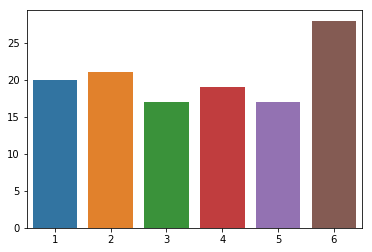

In [402]:
sns.barplot(x=np.arange(1, k+1), y=y);

Let's set up a simple model in PyMC3 that not only calculates the posterior probability for $theta$ (i.e. the probability for each side of the die), but also estimates the bias for throwing a $6$. 
We will use `Deterministic` variable, in addition to our unobserved (`theta`) and observed (`results`) variables.

In [403]:
with pm.Model() as dice_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    # Since theta[5] will hold the posterior probability of rolling a 6
    # we'll compare this to the reference value p = 1/6
    six_bias = pm.Deterministic("six_bias", theta[k-1] - p)
    
    results = pm.Multinomial("results", n=n, p=theta, observed=y)

Starting with version 3.5, PyMC3 includes a handy function to plot models in plate notation:

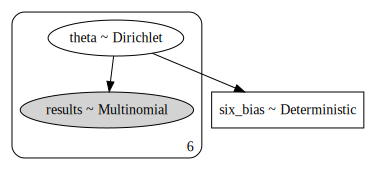

In [404]:
pm.model_to_graphviz(dice_model)

Let's draw 1,000 samples from the joint posterior using the default NUTS sampler:

In [405]:
with dice_model:
    dice_trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4105.55draws/s]


From the traceplot, we can already see that one of the $theta$ posteriors isn't in line with the rest:

/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


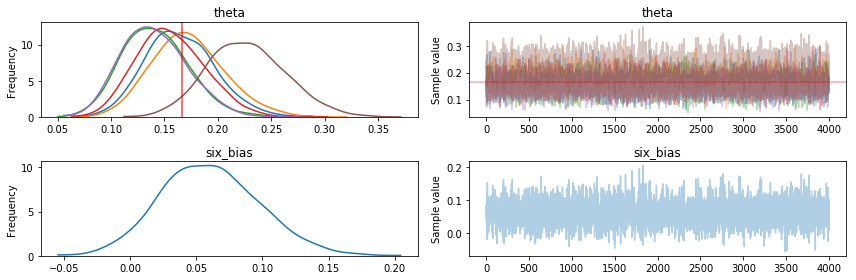

In [406]:
with dice_model:
    pm.traceplot(dice_trace, combined=True, lines={"theta": p})

We'll plot the posterior distributions for each $theta$ and compare it our reference value $p$ to see if the 95% HPD (Highest Posterior Density) interval includes $p = 1/6$.

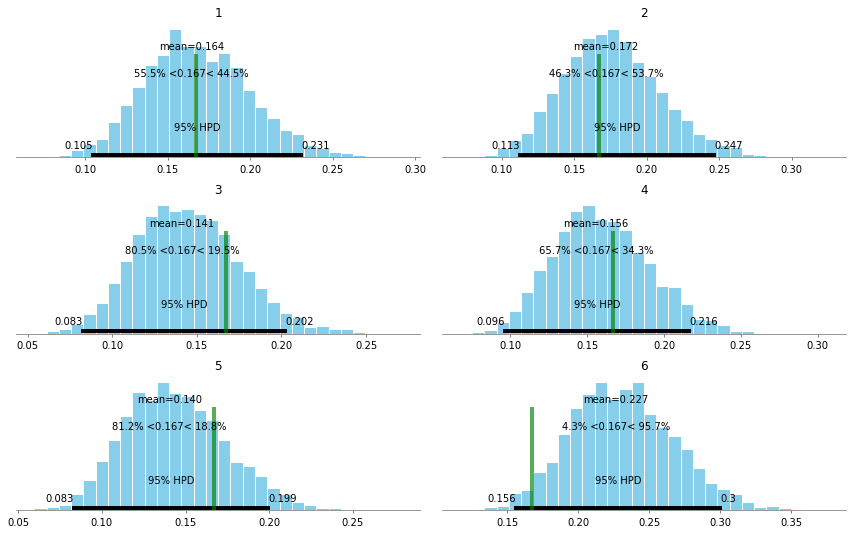

In [407]:
axes = pm.plot_posterior(dice_trace, varnames=["theta"], ref_val=np.round(p, 3))
for i, ax in enumerate(axes):
    ax.set_title(f"{i+1}")

We can clearly see that the HPD for the posterior probability for rolling a $6$ barely includes what we'd expect from a fair die.

To be more precise, let's plot the probability of our die being biased on $6$, by comparing $theta[Six]$ to $p$

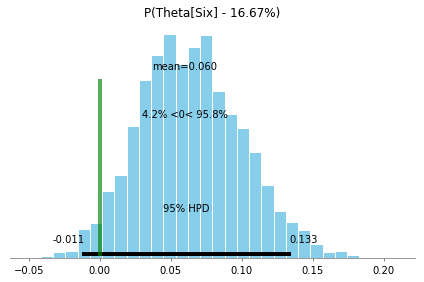

In [410]:
ax = pm.plot_posterior(dice_trace, varnames=["six_bias"], ref_val=[0])
ax.set_title(f"P(Theta[Six] - {p:.2%})");

Lastly, we can calculate the probability that the die is biased on $6$ by calculating the density to the right of our reference line at $0$:

In [411]:
six_bias_perc = len(dice_trace["six_bias"][dice_trace["six_bias"]>0])/len(dice_trace["six_bias"])
      
print(f'P(Six is biased) = {six_bias_perc:.2%}')

P(Six is biased) = 95.80%


Better get some new dice...!

## Polls #1

Let's turn our review of the Dirichlet-Multinomial distribution to another examples, concerning poll data. 

In section 3.4 of BDA3 on multivariate models and, specifically on multinomial models for categorical data, the authors include a, little dated, example of polling data in the 1988 Presidential race between George H.W. Bush and Michael Dukakis.

Here's the setup:

- 1,447 likely voters were surveyed
- Their responses were:
    - Bush: 727
    - Dukakis: 583
    - Other: 137
- What is the probability that more people will vote for Bush over Dukakis?

We set up the data, where $k$ represents the number of choices the respondents had:

In [415]:
n = 1447
y = np.asarray([727, 583, 137])
k = 3    

We, again, set up a simple Dirichlet-Multinomial model and include a `Deterministic` variable that calculates the metric of interest - the difference in probability of respondents for Bush vs. Dukakis.

In [416]:
with pm.Model() as polling_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    bush_dukakis_diff = pm.Deterministic("bush_dukakis_diff", theta[0] - theta[1])
    
    likelihood = pm.Multinomial("likelihood", n=n, p=theta, observed=y)

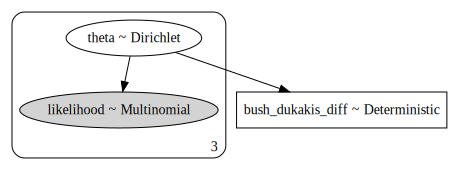

In [417]:
pm.model_to_graphviz(polling_model)

In [418]:
with polling_model:
    polling_trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4862.95draws/s]


/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


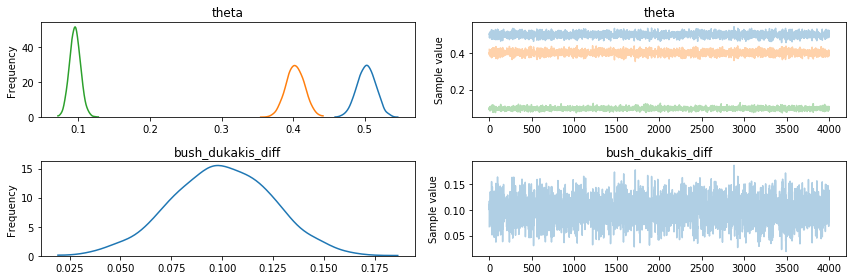

In [12]:
with polling_model:
    pm.traceplot(polling_trace, combined=True)

Looking at the % difference between respondents for Bush vs Dukakis, we can see that most of the density is greater than 0%, signifying a strong advantage for Bush in this poll.

We've also fit a $Beta$ distribution to this data via `scipy.stats`, and we can see that posterior of the difference of the 2 $theta$ values is a pretty good match.

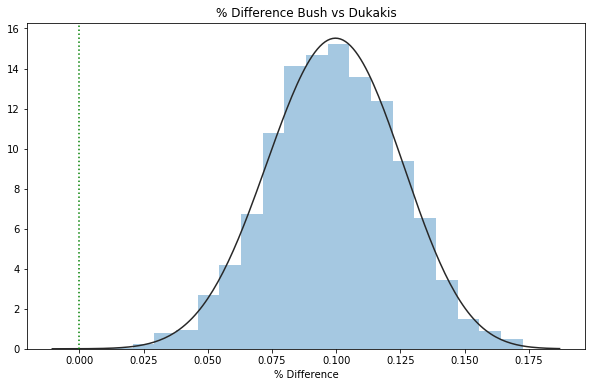

In [421]:
_, ax = plt.subplots(1,1, figsize=(10, 6))
sns.distplot(polling_trace["bush_dukakis_diff"], bins=20, ax=ax, kde=False, fit=stats.beta)
ax.axvline(0, c='g', linestyle='dotted')
ax.set_title("% Difference Bush vs Dukakis")
ax.set_xlabel("% Difference");

Percentage of samples with `bush_dukakis_diff > 0`:

In [422]:
bush_dukakis_diff_perc = len(polling_trace["bush_dukakis_diff"][polling_trace["bush_dukakis_diff"]>0])/len(polling_trace["bush_dukakis_diff"])
      
print(f'P(More Responses for Bush) = {bush_dukakis_diff_perc:.0%}')

P(More Responses for Bush) = 100%


## Polls #2

As an extension to the previous model, the authors of BDA include an exercise in chapter 3.10 (Exercise 2) that presents us with polling data from the 1988 Presidential race, taking _before_ and _after_ the one of the debates.

>  Comparison of two multinomial observations: on September 25, 1988, the evening of a
presidential campaign debate, ABC News conducted a survey of registered voters in the
United States; 639 persons were polled before the debate, and 639 different persons were
polled after. The results are displayed in Table 3.2. Assume the surveys are independent
simple random samples from the population of registered voters. Model the data with
two different multinomial distributions. For $j = 1, 2$, let $\alpha_j$ be the proportion of voters
who preferred Bush, out of those who had a preference for either Bush or Dukakis at
the time of survey $j$. Plot a histogram of the posterior density for $\alpha_2 − \alpha_1$. What is the
posterior probability that there was a shift toward Bush?

Let's copy the data from the exercise and model the problem as a probabilistic model, again using PyMC3:

In [425]:
data = pd.DataFrame([
        {"candidate": "bush", "pre": 294, "post": 288},
        {"candidate": "dukakis", "pre": 307, "post": 332},
        {"candidate": "other", "pre": 38, "post": 10}
       ], columns=["candidate", "pre", "post"])

In [426]:
data

,candidate,pre,post
0,bush,294,288
1,dukakis,307,332
2,other,38,10


Convert to 2x3 array

In [427]:
y = data[["pre", "post"]].T.values
y

array([[294, 307,  38],
       [288, 332,  10]])

Number of respondents in each survey

In [428]:
n = y.sum(axis=1) 
n

array([639, 630])

Number of respondents for the 2 major candidates in each survey

In [429]:
m = y[:, :2].sum(axis=1) 
m

array([601, 620])

For this model, we'll need to set up the priors slightly differently. Instead of 1 set of thetas, we need 2, one for each survey (pre/post debate).
To do that without creating specific pre/post versions of each variable, we'll take advantage of PyMC3's `shape` parameter, available for most (all?) distributions.

In this case, we'll need a 2-dimensional shape parameter, representing the number of debates `n_debates` and the number of choices in candidates `n_candidates`

In [430]:
n_debates, n_candidates = y.shape
n_debates, n_candidates

(2, 3)

Thus, we need to initialize a Dirichlet distribution prior with shape `(2,3)` and then refer to the relevant parameters by index where needed.

In [436]:
with pm.Model() as polling_model_debates:
    
    # initializes the Dirichlet distribution with a uniform prior:
    shape = (n_debates, n_candidates)
    a = np.ones(shape)
    
    # This creates a separate Dirichlet distribution for each debate
    # where sum of probabilities across candidates = 100% for each debate
    theta = pm.Dirichlet("theta", a=a, shape=shape)
    
    # get the "Bush" theta for each debate, at index=0
    bush_pref = pm.Deterministic("bush_pref", theta[:, 0] * n / m)
    
    # to calculate probability that support for Bush shifted from debate 1 [0] to 2 [1]
    bush_shift = pm.Deterministic("bush_shift", bush_pref[1]-bush_pref[0])
    
    # because of the shapes of the inputs, this essentially creates 2 multinomials, 
    # one for each debate
    responses = pm.Multinomial("responses", n=n, p=theta, observed=y)

/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


For models with multi-dimensional shapes, it's always good to check the shapes of the various parameters before sampling:

In [438]:
for v in polling_model_debates.unobserved_RVs:
    print(v, v.tag.test_value.shape)

theta_stickbreaking__ (2, 2)
theta (2, 3)
bush_pref (2,)
bush_shift ()


The plate notation visual can also help with that:

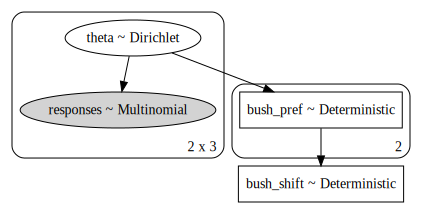

In [440]:
pm.model_to_graphviz(polling_model_debates)

Let's sample with a slightly higher number of draws and tuning steps:

In [441]:
with polling_model_debates:
    polling_trace_debates = pm.sample(draws=3000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 18000/18000 [00:04<00:00, 4099.18draws/s]


/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


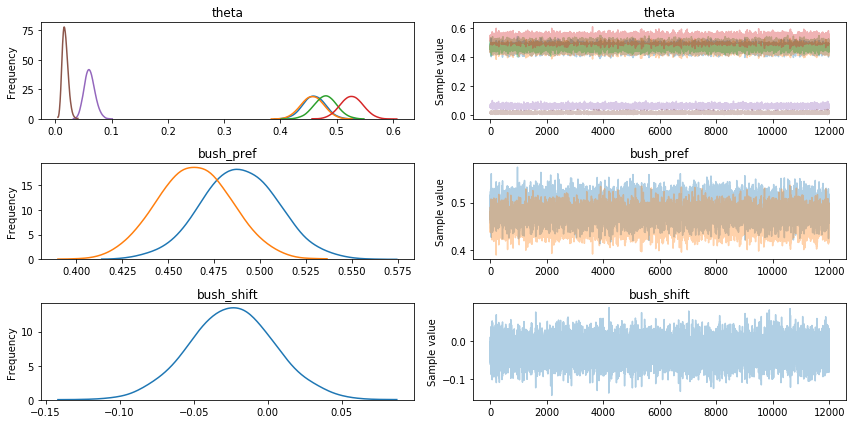

In [442]:
with polling_model_debates:
    pm.traceplot(polling_trace_debates, combined=True)

We'll take a look at the means of the posteriors for `theta`, indicating the % of support for each candidate pre & post debate:

In [290]:
polling_trace_debates["theta"].mean(axis=0)

array([[0.45946981, 0.4796844 , 0.06084579],
       [0.45668072, 0.52591642, 0.01740286]])

Just from the means, we can see that the number of Bush supporters has likely decreased post debate (as a % of supporters of the 2 major candidates):

In [448]:
s = ["pre", "post"]
[(s[j], v) for j, v in enumerate(polling_trace_debates["bush_pref"].mean(axis=0))]

[('pre', 0.48861667575986584), ('post', 0.46392802997898047)]

Let's compare the results visually, by plotting the posterior distributions of the pre/post debate values for % responses for Bush and the posterior for pre/post difference in Bush supporters:

/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


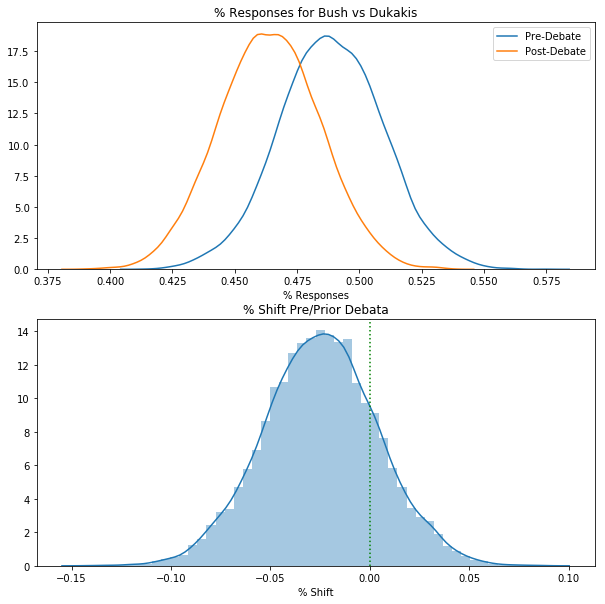

In [449]:
_, ax = plt.subplots(2,1, figsize=(10, 10))

sns.distplot(polling_trace_debates["bush_pref"][:,0], hist=False, ax=ax[0], label="Pre-Debate")
sns.distplot(polling_trace_debates["bush_pref"][:,1], hist=False, ax=ax[0], label="Post-Debate")
ax[0].set_title("% Responses for Bush vs Dukakis")
ax[0].set_xlabel("% Responses");

sns.distplot(polling_trace_debates["bush_shift"], hist=True, ax=ax[1], label="P(Bush Shift)")
ax[1].axvline(0, c='g', linestyle='dotted')
ax[1].set_title("% Shift Pre/Prior Debata")
ax[1].set_xlabel("% Shift");

From the second plot, we can already see that a large portion of the posterior density is below 0, but let's be precise and actually calculate the probability that support shifted _towards_ Bush after the debate:

In [450]:
perc_shift = (len(polling_trace_debates["bush_shift"][polling_trace_debates["bush_shift"] > 0])
              /len(polling_trace_debates["bush_shift"])
             )
print(f'P(Shift Towards Bush) = {perc_shift:.0%}')

P(Shift Towards Bush) = 19%


While that was a sort of round-about way to show that Bush lost support during the debate, hopefully this illustrated the flexibility and robustness of probabilistic models (and PyMC3).